# Model Defintion and Training

Now that we have parsed our training data, we can move on to defining our model. We will be using a number of different modules from pytorch:

- **torch.nn**
    - Provides the modules and classes we will use to define our network and its trainable layers
- **torch.nn.Functional**
    - Provides functional methods to compute functions that are stateless/not-trained (Activation functions, etc)
- **torch**
    - Used for creating and reshaping tensors throughout

To start, we need to load in the data we parsed during part 1. If you have not gone through part 1 yet, you should do so before running this notebook; alternatively, you can add some cells to load the data in a custom manner if you have it stored somewhere else.

In [2]:
# Again, this is a little bit of ipy magic
%store -r labels
%store -r images

### A brief discussion of PyTorch Tensors

Right now, the labels and images are stored as simple python lists. We'll use torch to convert them to tensors, which will allow us to easily apply more complex functions and transformations to the data.

In [3]:
import torch
training_labels = torch.tensor(labels)
training_images = torch.tensor(images)
print(type(training_images))

<class 'torch.Tensor'>


You can see above that we've converted our list into an object of class `torch.Tensor`. We'll need to keep our data as this type during the training and evaluation periods of our model. 

Although they may seem weird at first, you'll find a lot of familiarity with Tensor classes if you've worked with numpy before. In fact, you can even iterate through them like regular old lists:

In [4]:
tensor = torch.tensor([[1,2,3], [4,5,6], [7,8,9]])
for i, row in enumerate(tensor):
    print(f"Row {i}: {row}")

Row 0: tensor([1, 2, 3])
Row 1: tensor([4, 5, 6])
Row 2: tensor([7, 8, 9])


Similarily, if we wanted to iterate through the columns in our tensor:

In [5]:
for i, col in enumerate(tensor.T):
    print(f" Column {i}: {col}")

 Column 0: tensor([1, 4, 7])
 Column 1: tensor([2, 5, 8])
 Column 2: tensor([3, 6, 9])


I'm not going to go into too much more detail on tensor operations. Not only will you learn far more from the [documentation](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py), but I believe it's better to learn the power of tensors by seeing them in action.

The one last thing I'll show you is in-place operations on tensors. This differs a bit from numpy, so I'm calling it out now as we will be using it later on in this notebook:

In [6]:
tensor_1 = torch.ones(1,3)  
tensor_2 = tensor_1.sub(1)    # Not in place. Returns a new tensor
print(f"tensor_1: {tensor_1}")
print(f"tensor 2: {tensor_2}\n")

tensor_2 = tensor_1.sub_(1)  # In place. Modifies the tensor and returns a reference
print(f"tensor_1: {tensor_1}")
print(f"tensor_2: {tensor_2}\n")

# Be careful capturing the output of in-place operations, as you must keep strict track of them to avoid unintentionally modifying data later on.

tensor_2.sub_(1)
print(f"tensor_1: {tensor_1}")  # We've also modified the original tensor variable
print(f"tensor_2: {tensor_2}")

tensor_1: tensor([[1., 1., 1.]])
tensor 2: tensor([[0., 0., 0.]])

tensor_1: tensor([[0., 0., 0.]])
tensor_2: tensor([[0., 0., 0.]])

tensor_1: tensor([[-1., -1., -1.]])
tensor_2: tensor([[-1., -1., -1.]])


### Re-shaping our data for the model

I am going to be a bit of an oracle here, and tell you that our first pass at a torch neural network is going to expect the image data as a rank 1, 784 dimensional tensor. This is **not** the best way to learn from this data, as we are  totally blowing away any information about the vertical orientation of the pixels; but, it keeps things simple to start off with. We'll talk about 2d representation of the data later on.

The other thing I will drag out of my crystal ball is that we will define our target label for any given input as a 10 dimensional vector (rank 1 tensor) where the value at every index is 0 except that of the target digit, which will be a 1.

Now that we have our images and labels stored as `tensors`, these transformations become trivial:

In [7]:
training_images = training_images.reshape(60000, 1, 784).float()  # 60000 images, 1 grayscale channel, 784 pixels

Note that if we ever want to display out one of these images, we'll have to reshape it back into something that plt can understand. That 'something' is a 2d numpy array

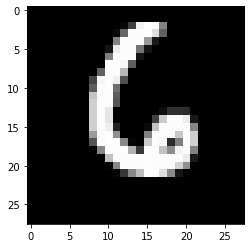

In [8]:
import matplotlib.pyplot as plt
image_index = torch.randint(len(training_images), (1,)).item()
viewable_image = training_images[image_index].numpy().reshape(28,28)
plt.imshow(viewable_image, cmap='gray')
plt.show()

Now, let's "reshape" the label tensor into a new one that has a 10 dimensions vector for each label. Think about why I put "reshape" in quotes. In order to turn our label tensor from from a single 60000 dimensional vector to 60000 10 dimensional vectors, we are actually changing the "space" that our labels live in. This transformation changes the size of the space, so we need to make a new tensor.

In [9]:
new_labels = torch.zeros(60000, 10)            # Start everything as a zero
for i, label in enumerate(training_labels):    # Enumerate through our labels and set the value at each index to 1
    new_labels[i][label] = 1

Just for ease of use, we'll replace the original training_labels variable with the new one

In [10]:
training_labels = new_labels.float()

### Building our  model
Alright! We've got our training data in the shape and form we need it. Now we can go ahead and define our model. I'm not going to dive deep into the fundamentals of neural networks (I still have a lot to learn myself), but I'll share some guesses about our data that will inform our layer architecture.

- Pixels in the flattened image will have a horizontal relationship to each other. In other words, it's probably valuable to know how the value of one pixel relates to the values of its neighbor(s). We can add a 1d convolutional layer to capture this information and identify whether certain "features" are present in locations along the flat image.


- Once we have computed how pixels relate to their neighbors, we'll want to think about how these computed features can be reduced to smaller space. We can use a fully connected linear layer for this.


- Finally, we want to take the output of that linear layer and squeeze it down even more, using the knowledge of the relationships between pixels and the "features" of the image they define to create our output vector which represents what digit the network thinks the image is

##### Note:  practioners or students of classification neural networks will immediately know that this can be accomplished with a far less complicated model that realizes far better results. But we're going to use a convolutional layer because this is more about using pytorch than building the best possible model.

#### The model class
Our model class will inherit from the `nn.Module` class, which will automatically give us tools to track weights, biases, and gradients across our layers and easily perform feed-forward training and backpropogation adjustments.

In our `__init__` method, we'll define the layers we mentioned above. We'll define just one more method, which is `forward` method, which represents what happens when an image makes a forward pass through our network.

In [11]:
import torch.nn as nn
import torch.nn.functional as F
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv1d(1,1,3)      # Convolutional layer. 1 input channel, 1 output channel, kernel size 3
        self.fc1 = nn.Linear(782, 100)     # First linear layer. Takes the output of our convolution and reduces features
        self.fc2 = nn.Linear(100,10)       # Second linear and final layer. Converts to image classification vector
        
    def forward(self, x):
        x = F.sigmoid(self.conv1(x))       # Sigmoid activation of our conv layer
        x = x.view(-1, x.shape[1:].numel())# Reshape for linear layers
        x = F.sigmoid(self.fc1(x))
        return self.fc2(x)
        

There we have it. We've defined our model in about 10 lines. 

If you've used python before, it's likely very obvious how the above class implements to our proposed model architecture, but we'll do a quick overview to be sure.

1. In the `__init__` method, we define our 3 layers as instance variables of our class: 1 Convolutional layer and 2 linear layers. It's important to set these layers here, so that pytorch's automatic gradient calculation (`autograd`) works as we expect.


2. In the `forward` method, we simply move some input `x` through our layers by providing it as an input to each instance variable. We'll wrap these calls in the activation function of our choice when appropriate.

If you're wondering about the `x = x.view(-1, x.shape[1:].numel())` step, you should know that it's reshaping the activations out of the convolutional layer to be the proper shape for our linear layers. PyTorch expects everything to have a batch dimension--which means that even when running our network on a single flattened grayscale image, the input shape is [1,1,784], not [1,784]. After our convolution, we want to flatten our activations to just be [1, a], where a is the number of elements after the peforming activation(convolution(input)) for a single image. You can extrapolate this to batched inputs, so the shape becomes [n, a], where n is the size of the mini-batch. Depending on your network architeture, this reshape may not always happen before your first linear layer.

### Training our Model
Now that we've defined our model in a class, it's time to train.

We start by just instantiating our model as we would any other python class

In [18]:
net = MNISTNet()

#### The training loop
We are going to write a lot of the training loop by hand, because I think it actually better shows the power of PyTorch. There are lots of powerful tools for training, like [DataLoaders](https://pytorch.org/docs/stable/data.html) and [optimizers](https://pytorch.org/docs/stable/optim.html), but using these right from the start sort of hides the inner awesomeness of PyTorch's `autograd` and `nn.Module` functionality. Also, writing it by hand is a good refresher of the concepts of how neural nets train without having to spend time writing all the backpropgation and gradient calculations yourself (thanks PyTorch).

I'm just going to dump the whole loop here to start, and I'll break down the intersesting parts below it.

In [19]:
from IPython.display import display, clear_output
MINI_BATCH = 4
criterion = nn.MSELoss()
EPOCHS = 3
NUM_BATCHES = len(training_images) // MINI_BATCH
net.train()
for e in range(EPOCHS):
    perm = torch.randperm(60000)
    running_loss = 0.0
    for i in range(NUM_BATCHES):
        indexes = perm[i*MINI_BATCH:(i+1) * MINI_BATCH]
        batch = training_images[indexes]
        targets = training_labels[indexes]
        
        net.zero_grad()
        out = net(batch)
        loss = criterion(out, targets)
        loss.backward()
        running_loss += loss.item()
        if i % 1000 == 999:
            clear_output(wait=True)
            display(f"Epoch: {e}, Batch: {i}, running_loss: {running_loss}")
            running_loss = 0.0
        for f in net.parameters():
            f.data.sub_(f.grad.data * .01)

'Epoch: 0, Batch: 6999, running_loss: 159.20936676114798'

KeyboardInterrupt: 

Let's talk about a few parts of this loop

- ```criterion = nn.MSELoss()``` this is how we declare our cost/loss function. In this first pass at the network, we're using Mean Squared Error or Quadratic loss. When we do ```loss = criterion(out, targets)```, pytorch computes the loss for the given mini batch.


- ```loss.backward()```. Here's where the magic starts. PyTorch keeps a graph of all operations carried out on all the parameters (weights, biases) for each layer in our network. When we call `loss.backward()`, PyTorch automatically calculates the gradient of our cost function w.r.t. the activations of our output layer. It then calculates the error of the output layer and backprops it through every path in the network, using it to compute the gradient for each weight and bias along the way.


- ```
for f in net.parameters():
    f.data.sub_(f.grad.data * .01)
``` 
here, we're manually performing stochagradient descent on the parameters (again, weights, biases) for each layer in our network. F.grad.data contains the gradients for each layer as computed by `loss.backward()`. If you're confused how this line updates the weights 


- ```net.zero_grad()``` PyTorch automatically accumulates gradients across multiple `loss.backward()` calls. This has some usefulness in RNNs or in cases where you run multiple batches before optimizing, but in our use case we don't want it. Summing the gradients of weights / biases w.r.t loss over multiple training/optimization steps will not help our network learn. We use the `zero_grad()` function to zero the gradient of each parameter at the start of each mini-batch training iteration.

In [14]:


import numpy as np
with open("./data/processed_testing_labels.csv") as labels_file:
    labels_string = labels_file.read()
    testing_labels = np.array(labels_string.split(','), dtype=int)
    
# Recall we had 60000 images. Let's make sure we didn't lose anythin
assert len(testing_labels) == 10000

# Now for the images
testing_images = []
with open("./data/processed_testing_images") as images_file:
    raw_image_strings = images_file.readlines()
    for img_string in raw_image_strings:
        img_flat = np.array(img_string.split(","), dtype=np.double)
        img = np.reshape(img_flat, (28,28))
        testing_images.append(img)

In [15]:
t_test_labels = torch.tensor(testing_labels)
t_test_images = torch.tensor(testing_images)

In [16]:
test_imgs = t_test_images
test_labels = t_test_labels
correct = []
net.eval()
for i,img in enumerate(test_imgs):
    res = torch.argmax(net(img.flatten().float().unsqueeze(0).unsqueeze(0)))
    targ = test_labels[i]
    if res == targ:
        correct.append(1)
    else:
        correct.append(0)

print(f"{sum(correct)} / {len(correct)}")

8440 / 10000
